In [101]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

In [102]:
columns = ["calls",  "minutes",  "message","md_used", "is_ultra"]
df = pd.read_csv("users_behavior.csv",
                 names=columns,
                 header=1) 

In [103]:
df.head()

,calls,minutes,message,md_used,is_ultra
0,85.0,516.75,56.0,22696.96,0
1,77.0,467.66,86.0,21060.45,0
2,106.0,745.53,81.0,8437.39,1
3,66.0,418.74,1.0,14502.75,0
4,58.0,344.56,21.0,15823.37,0


In [104]:
X = df.drop(columns=['is_ultra']) 
y = df['is_ultra']
# train, valid, test = np.split(df.sample(frac=1, random_state=42), [int(.6*len(df)), int(.8*len(df))])

In [105]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [106]:
y_train

2369    1
2234    0
1058    0
118     0
1024    1
       ..
1095    0
1130    0
1294    1
860     1
3174    0
Name: is_ultra, Length: 1927, dtype: int64

In [107]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)
y_train = np.array(y_train)

In [108]:
rfc = RandomForestClassifier()
rfc.fit(X_train_scaled, y_train)
display(rfc.score(X_train_scaled, y_train))

1.0

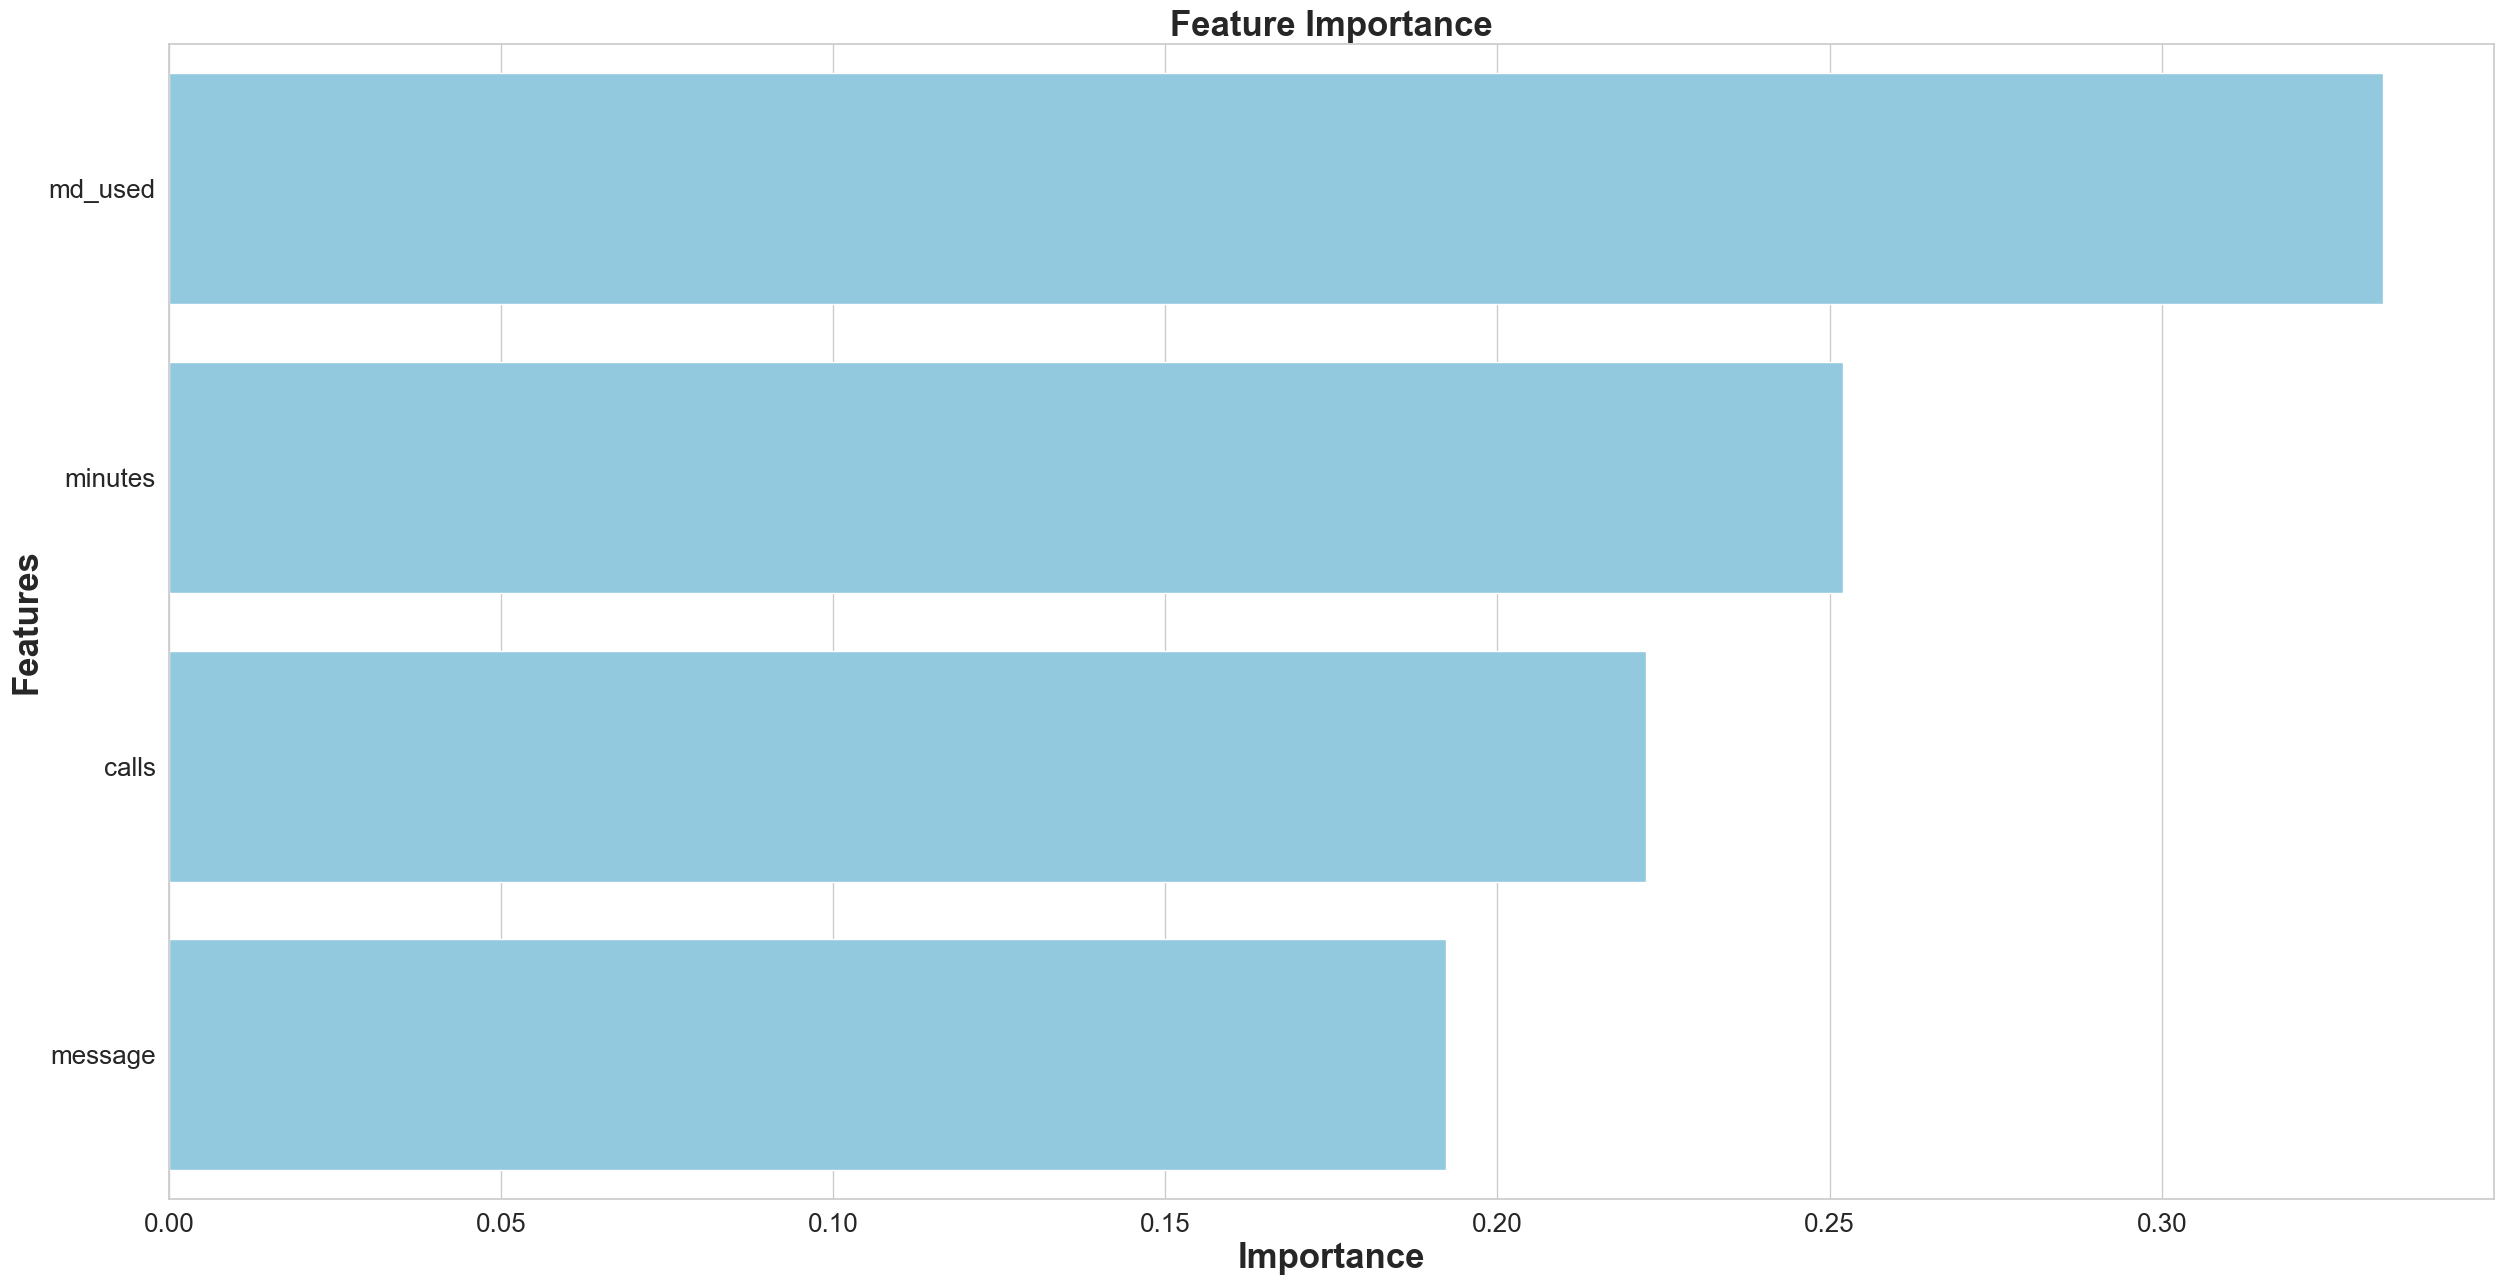

None

,Features,Gini-Importance
0,md_used,0.333322
1,minutes,0.252067
2,calls,0.222430
3,message,0.192181


In [109]:
feats = {}
for feature, importance in zip(df.columns, rfc.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

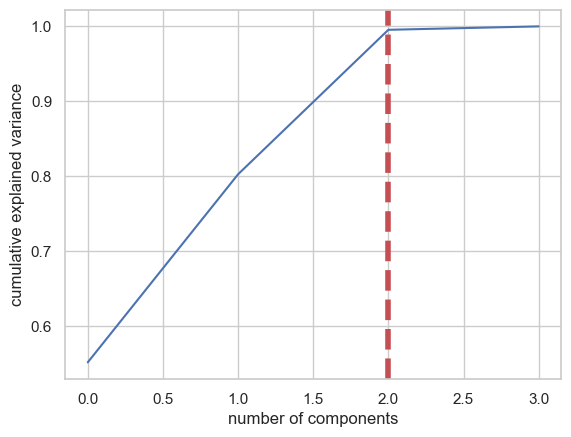

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.552110,0.552110
1,0.802812,0.250701
2,0.995428,0.192617
3,1.000000,0.004572


In [110]:
n_components = min(X_train_scaled.shape[0], X_train_scaled.shape[1])

pca_test = PCA(n_components=n_components)
pca_test.fit(X_train_scaled)

sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=2, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(10))

In [111]:
pca = PCA(n_components=4)
pca.fit(X_train_scaled)
X_train_scaled_pca = pca.transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

In [112]:
pca_dims = []
for x in range(0, len(pca_df)):
    pca_dims.append('PCA Component {}'.format(x))
pca_test_df = pd.DataFrame(pca_test.components_, columns=["calls",  "minutes",  "message","md_used"], index=pca_dims)
pca_test_df.head(10).T

,PCA Component 0,PCA Component 1,PCA Component 2,PCA Component 3
calls,0.640142,-0.276086,-0.110496,-0.708368
minutes,0.638016,-0.285141,-0.116064,0.705804
message,0.244526,0.786060,-0.567720,0.003165
md_used,0.351227,0.473899,0.807474,0.006741


In [113]:
rfc = RandomForestClassifier()
rfc.fit(X_train_scaled_pca, y_train)
display(rfc.score(X_train_scaled_pca, y_train))

1.0

In [114]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(
    start = 2, 
    stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(rfc, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)
rs.fit(X_train_scaled_pca, y_train)
rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 1000,
 'min_samples_split': 12,
 'min_samples_leaf': 7,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [115]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head()

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,1000,12,7,sqrt,10,True,0.809552,1
1,700,18,7,sqrt,7,False,0.808510,2
2,700,2,2,log2,11,True,0.807479,3
3,500,18,7,log2,7,True,0.806959,4
4,300,28,7,log2,13,True,0.804882,5


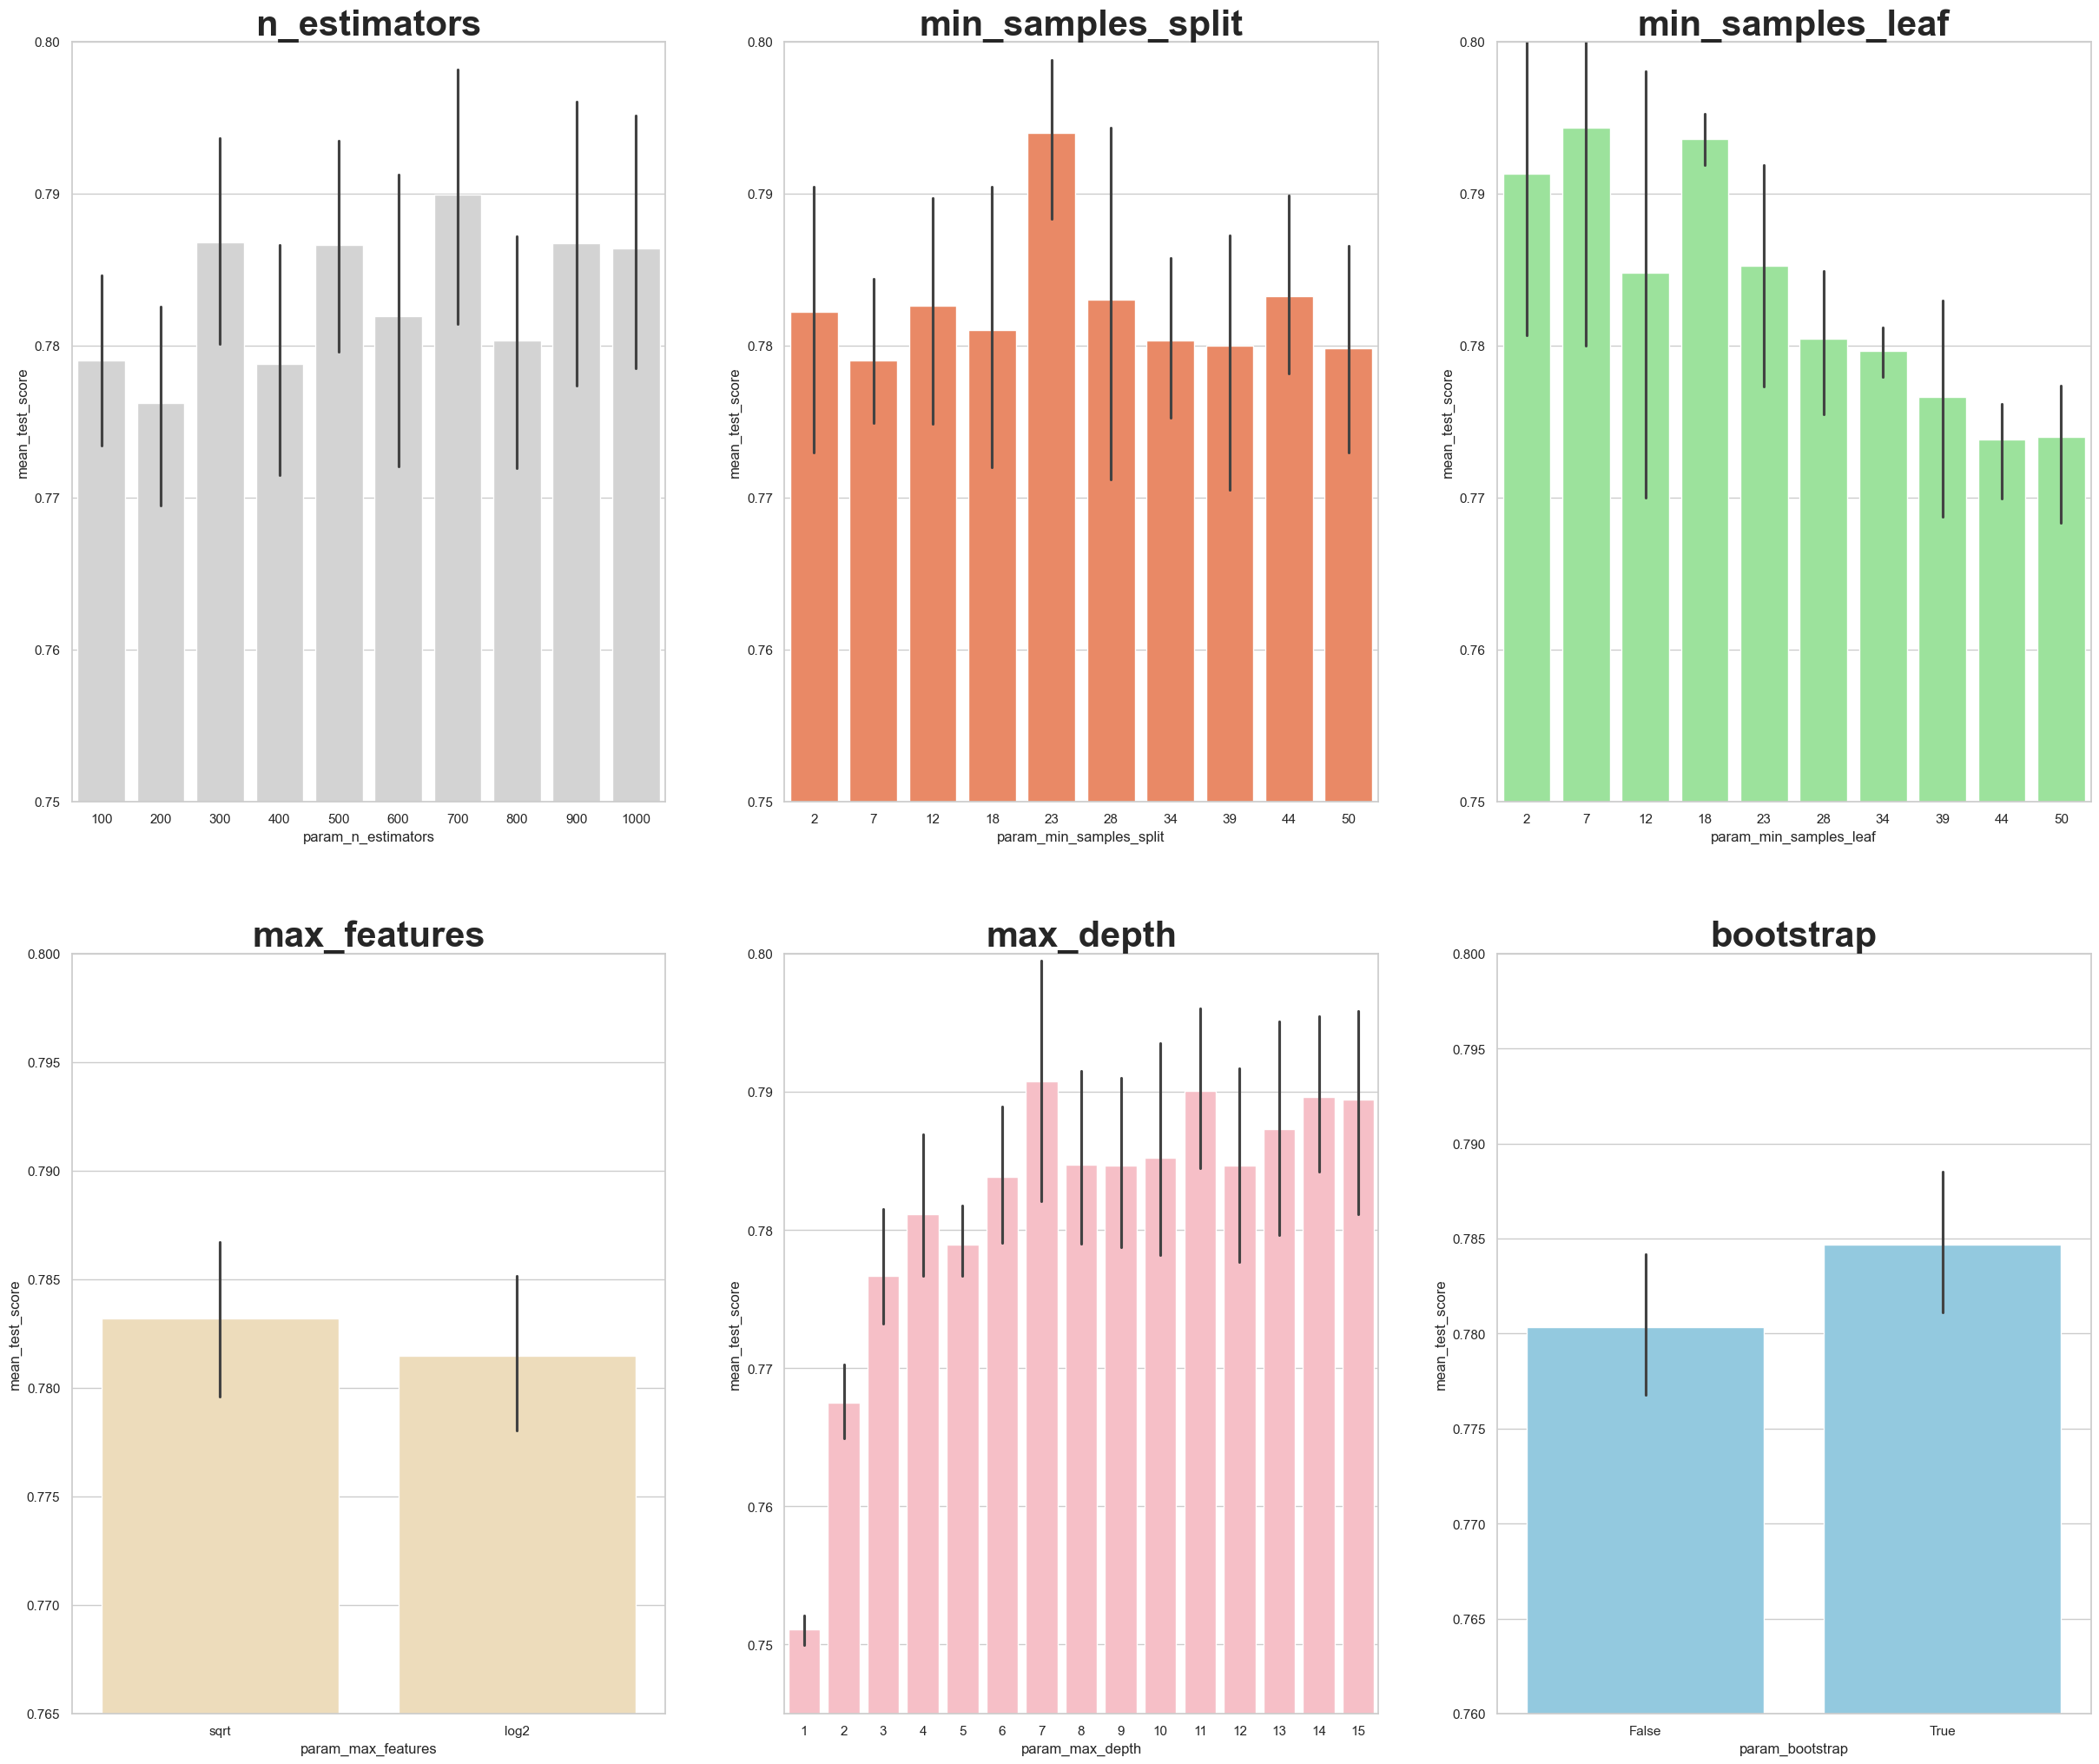

In [116]:
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)

sns.barplot(x=rs_df.param_n_estimators, y=rs_df.mean_test_score, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.75,.80])
axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')
sns.barplot(x=rs_df.param_min_samples_split, y=rs_df.mean_test_score,  ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.75,.80])
axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')
sns.barplot(x=rs_df.param_min_samples_leaf, y=rs_df.mean_test_score, ax=axs[0,2], color='lightgreen')
axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')
axs[0,2].set_ylim([.75,.80])
sns.barplot(x=rs_df.param_max_features, y=rs_df.mean_test_score, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([.765,.80])
axs[1,0].set_title(label = 'max_features', size=30, weight='bold')
sns.barplot(x=rs_df.param_max_depth, y=rs_df.mean_test_score, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([.745,.80])
axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')
sns.barplot(x=rs_df.param_bootstrap,y=rs_df.mean_test_score, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([.76,.80])
axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')
plt.show()

In [117]:
n_estimators = [300,500,700]
max_features = ['sqrt']
max_depth = [2,3,7,11,15]
min_samples_split = [2,3,4,22,23,24]
min_samples_leaf = [2,3,4,5,6,7]
bootstrap = [False]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
gs = GridSearchCV(rfc, param_grid, cv = 3, verbose = 1, n_jobs=-1)
gs.fit(X_train_scaled_pca, y_train)
rfc_3 = gs.best_estimator_
gs.best_params_

Fitting 3 folds for each of 540 candidates, totalling 1620 fits


{'bootstrap': False,
 'max_depth': 7,
 'max_features': 'sqrt',
 'min_samples_leaf': 7,
 'min_samples_split': 3,
 'n_estimators': 300}

In [118]:
y_pred = rfc.predict(X_test_scaled)
y_pred_pca = rfc.predict(X_test_scaled_pca)
y_pred_gs = gs.best_estimator_.predict(X_test_scaled_pca)

In [119]:
conf_matrix_baseline = pd.DataFrame(confusion_matrix(y_test, y_pred), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
conf_matrix_baseline_pca = pd.DataFrame(confusion_matrix(y_test, y_pred_pca), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
conf_matrix_tuned_pca = pd.DataFrame(confusion_matrix(y_test, y_pred_gs), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
display(conf_matrix_baseline)
display('Baseline Random Forest recall score', recall_score(y_test, y_pred))
display(conf_matrix_baseline_pca)
display('Baseline Random Forest With PCA recall score', recall_score(y_test, y_pred_pca))
display(conf_matrix_tuned_pca)
display('Hyperparameter Tuned Random Forest With PCA Reduced Dimensionality recall score', recall_score(y_test, y_pred_gs))

,predicted 0,predicted 1
actual 0,373,79
actual 1,102,89


'Baseline Random Forest recall score'

0.46596858638743455

,predicted 0,predicted 1
actual 0,406,46
actual 1,77,114


'Baseline Random Forest With PCA recall score'

0.5968586387434555

,predicted 0,predicted 1
actual 0,413,39
actual 1,86,105


'Hyperparameter Tuned Random Forest With PCA Reduced Dimensionality recall score'

0.5497382198952879

In [120]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [121]:
y_valid_pred = model.predict(X_valid)
valid_accuracy = accuracy_score(y_valid, y_valid_pred)
print(f'Accuracy на валидационной выборке: {valid_accuracy:.4f}')

Accuracy на валидационной выборке: 0.7838


In [122]:
y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Accuracy на тестовой выборке: {test_accuracy:.4f}')

Accuracy на тестовой выборке: 0.8025
